## Final Project - Basics of deep learning

---
<br>

### Name and ID:
Student 1: Eyal Pasha, 213957814
<br>
Student 2: Nir Tuttnauer, 208585422

## **Chest X-Ray Images (Pneumonia) Dataset**


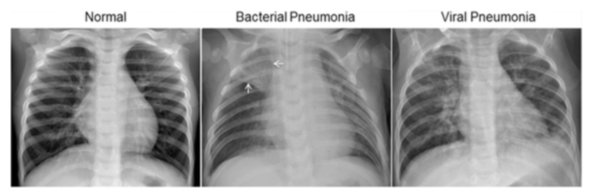

The normal chest X-ray (left panel) depicts clear lungs without any areas of abnormal opacification in the image. Bacterial pneumonia (middle) typically exhibits a focal lobar consolidation, in this case in the right upper lobe (white arrows), whereas viral pneumonia (right) manifests with a more diffuse ‘‘interstitial’’ pattern in both lungs.

Link: https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


<br>
<br>
Content:

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

<br>

Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2


## **Setup**

**Imports**

In [ ]:
import os
import shutil
import numpy as np
import zipfile
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.preprocessing import image
from sklearn.neighbors import KNeighborsClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.optimizers import  SGD
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.applications import VGG16, DenseNet121
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D, Input, Concatenate, UpSampling2D, ReLU)
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
def model_full_report(model,history, test_generator):
    # Plot training and validation accuracy values
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot training and validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Make predictions using the model
    predictions = model.predict(test_generator)

    # Get predicted labels (argmax to get the class with the highest probability)
    predicted_labels = predictions.argmax(axis=1)

    # Get true labels
    true_labels = test_generator.classes

    # Generate a classification report
    report = classification_report(true_labels, predicted_labels)

    # Print the classification report
    print("Classification Report:\n", report)

def save_model(model, model_filename='unnamed.h5'):
    weights_filename = os.path.splitext(model_filename)[0] + '_w.h5'
    model.save(model_filename)
    model.save_weights(weights_filename)

def save_history(history, filename='unnamed.npy'):
    np.save(filename, history)

def load_saved_model(model_filename='unnamed.h5'):
    return load_model(model_filename)

def load_saved_history(filename='unnamed.npy'):
    return np.load(filename, allow_pickle=True).item()

class Config:
    def __init__(self, img_width=256, img_height=256, epochs=10, batch_size=32, learning_rate=0.0001):
        self.img_width = img_width
        self.img_height = img_height
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate

    def generate_data(self, train_data_dir, test_data_dir):
        # Data augmentation for training set
        train_datagen = ImageDataGenerator(
            rescale=1. / 255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

        # Only rescaling for validation/test set
        test_datagen = ImageDataGenerator(rescale=1. / 255)

        # Generating training set
        train_generator = train_datagen.flow_from_directory(
            train_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating validation set
        validation_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary'
        )

        # Generating test set
        test_generator = test_datagen.flow_from_directory(
            test_data_dir,
            target_size=(self.img_width, self.img_height),
            batch_size=self.batch_size,
            class_mode='binary',
            shuffle=False  # Ensure the order of predictions matches the order of actual labels
        )

        return train_generator, validation_generator, test_generator


**GPU Check Script**

In [ ]:
# import tensorflow as tf

# cifar = tf.keras.datasets.cifar100
# (x_train, y_train), (x_test, y_test) = cifar.load_data()
# model = tf.keras.applications.ResNet50(
#     include_top=True,
#     weights=None,
#     input_shape=(32, 32, 3),
#     classes=100,)

# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
# model.fit(x_train, y_train, epochs=5, batch_size=64)

**For Google Drive**

In [ ]:
drive.mount('/content/drive')

**Data extraction and reorganization**

In [ ]:
# Specify the path to the zip file and the extraction directory
zip_path = '/content/drive/MyDrive/dataset.zip'
extracted_path = '/content/dataset'

# Extract the contents of the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

# Function to delete a directory and its contents
def delete_directory(path):
    try:
        shutil.rmtree(path)
        print(f"Directory '{path}' successfully deleted.")
    except FileNotFoundError:
        print(f"Directory '{path}' not found.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Define the paths to the directories you want to delete
dir_to_delete1 = '/content/dataset/chest_xray/__MACOSX'
dir_to_delete2 = '/content/dataset/chest_xray/val'
dir_to_delete3 = '/content/dataset/chest_xray/chest_xray/val'

# Delete the first directory
delete_directory(dir_to_delete1)

# Move NORMAL images from val to train
src_path_normal = '/content/dataset/chest_xray/val/NORMAL'
dest_path_normal = '/content/dataset/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_normal):
    shutil.move(os.path.join(src_path_normal, filename), os.path.join(dest_path_normal, filename))

# Move PNEUMONIA images from val to val/NORMAL
src_path_pneumonia = '/content/dataset/chest_xray/val/PNEUMONIA'
dest_path_pneumonia = '/content/dataset/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia):
    shutil.move(os.path.join(src_path_pneumonia, filename), os.path.join(dest_path_pneumonia, filename))

# Move NORMAL images from chest_xray/val to chest_xray/train
src_path_chest_xray_normal = '/content/dataset/chest_xray/chest_xray/val/NORMAL'
dest_path_chest_xray_normal = '/content/dataset/chest_xray/chest_xray/train/NORMAL'

for filename in os.listdir(src_path_chest_xray_normal):
    shutil.move(os.path.join(src_path_chest_xray_normal, filename), os.path.join(dest_path_chest_xray_normal, filename))

# Move PNEUMONIA images from chest_xray/val to chest_xray/val/NORMAL
src_path_pneumonia_chest_xray = '/content/dataset/chest_xray/chest_xray/val/PNEUMONIA'
dest_path_pneumonia_chest_xray = '/content/dataset/chest_xray/chest_xray/val/NORMAL'

for filename in os.listdir(src_path_pneumonia_chest_xray):
    shutil.move(os.path.join(src_path_pneumonia_chest_xray, filename), os.path.join(dest_path_pneumonia_chest_xray, filename))

# Delete the 'val' folders
delete_directory(dir_to_delete2)
delete_directory(dir_to_delete3)

# Define the paths for the test directory
test_dir = '/content/dataset/chest_xray/chest_xray/test'
src_path_pneumonia_test = os.path.join(test_dir, 'PNEUMONIA')
dest_path_bacterial = os.path.join(test_dir, 'BACTERIAL')
dest_path_viral = os.path.join(test_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders
os.makedirs(dest_path_bacterial, exist_ok=True)
os.makedirs(dest_path_viral, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_test):
    src_file_path = os.path.join(src_path_pneumonia_test, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the test directory
delete_directory(src_path_pneumonia_test)

# Define the paths for the train directory
train_dir = '/content/dataset/chest_xray/chest_xray/train'
src_path_pneumonia_train = os.path.join(train_dir, 'PNEUMONIA')
dest_path_bacterial_train = os.path.join(train_dir, 'BACTERIAL')
dest_path_viral_train = os.path.join(train_dir, 'VIRAL')

# Create the BACTERIAL and VIRAL folders in the train directory
os.makedirs(dest_path_bacterial_train, exist_ok=True)
os.makedirs(dest_path_viral_train, exist_ok=True)

# Split images between BACTERIAL and VIRAL based on the presence of words in the filename
for filename in os.listdir(src_path_pneumonia_train):
    src_file_path = os.path.join(src_path_pneumonia_train, filename)

    if "bacteria" in filename.lower():
        dest_file_path = os.path.join(dest_path_bacterial_train, filename)
    elif "virus" in filename.lower():
        dest_file_path = os.path.join(dest_path_viral_train, filename)
    else:
        # Skip files that don't contain "bacteria" or "virus" in the filename
        continue

    shutil.move(src_file_path, dest_file_path)

# Delete the 'PNEUMONIA' folder in the train directory
delete_directory(src_path_pneumonia_train)

# Display success message
print("Data extraction, modification, and splitting completed.")

Directory 'dataset/chest_xray/__MACOSX' successfully deleted.
Directory 'dataset/chest_xray/val' successfully deleted.
Directory 'dataset/chest_xray/chest_xray/val' successfully deleted.
Directory 'dataset/chest_xray/chest_xray/test/PNEUMONIA' successfully deleted.
Directory 'dataset/chest_xray/chest_xray/train/PNEUMONIA' successfully deleted.
Data extraction, modification, and splitting completed.


Unmount for Drive

In [ ]:
# drive.flush_and_unmount()

## **Task 1 - Binary Classifiaction**

**Preping the data**

In [ ]:

# Set the paths
train_data_dir = 'dataset/chest_xray/train'
test_data_dir = 'dataset/chest_xray/test'

# # Set the paths for drive
# train_data_dir = 'content/dataset/chest_xray/train'
# test_data_dir = 'content/dataset/chest_xray/test'

# Define parameters
config = Config(img_width=256, img_height=256, epochs=10, batch_size=32, learning_rate=0.0001)

# Generate data using the config
train_generator, validation_generator, test_generator = config.generate_data(train_data_dir, test_data_dir)


Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Set the paths
train_data_dir = 'dataset/chest_xray/train'
test_data_dir = 'dataset/chest_xray/test'

# Define parameters
img_width, img_height = 256, 256
epochs = 50
batch_size = 32
learning_rate = 0.0001

# Data augmentation for training set
train_datagen = ImageDataGenerator(
rescale=1. / 255,
rotation_range=15,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
fill_mode='nearest'
)

# Only rescaling for validation/test set
test_datagen = ImageDataGenerator(rescale=1. / 255)

# Generating training set
train_generator = train_datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary'
)

# Generating validation set
validation_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
test_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='binary',
shuffle=False # Ensure the order of predictions matches the order of actual labels
)

Found 5224 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


**Subset train**

In [ ]:
##Load model again:
loaded_model = load_model('models/1/binary_classification_model.h5')
loaded_model.load_weights('models/1/binary_classification_weights.h5')
loaded_history = load_saved_history('models/1/binary_classification_history.npy')


OSError: No file or directory found at models/1/binary_classification_model.h5

In [ ]:
model_full_report(loaded_model,loaded_history,test_generator)

Load Model

In [ ]:
# Load the trained model with full dataset weights
model_full = load_model('models/1/binary_classification_model_full_dataset.h5')
model_full.load_weights('models/1/binary_classification_weights_full_dataset.h5')

In [ ]:
# Get class labels
class_labels = {0: 'Normal', 1: 'Pneumonia'}

# Get 10 random images from the test set
random_indices = np.random.choice(len(test_generator.filenames), size=10, replace=False)

# Display the images and predictions
plt.figure(figsize=(15, 8))
for i, idx in enumerate(random_indices):
  img_path = os.path.join(test_data_dir, test_generator.filenames[idx])
  img = image.load_img(img_path, target_size=(img_width, img_height), color_mode='rgb')
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0) / 255.0 # Rescale pixel values
  true_label = test_generator.classes[idx]

# Make predictions
  prediction = model_full.predict(img_array)
  predicted_label = int(np.round(prediction[0]))

# Display the image with true and predicted labels
  plt.subplot(2, 5, i+1)
  plt.imshow(img, cmap='gray')
  plt.title(f'True: {class_labels[true_label]}\nPredicted: {class_labels[predicted_label]}')
  plt.axis('off')

plt.tight_layout()
plt.show()

NameError: name 'model_full' is not defined

<Figure size 1500x800 with 0 Axes>

# **Task 2 - Multi-Class**

**Data prep**

In [ ]:
# Set paths
train_data_dir_multi = 'dataset/chest_xray/chest_xray/train'
test_data_dir_multi = 'dataset/chest_xray/chest_xray/test'

# Data generator with data augmentation for training
train_datagen_multi = ImageDataGenerator(rescale=1./255,
                                         shear_range=0.2,
                                         zoom_range=0.2,
                                         horizontal_flip=True,
                                         rotation_range=15)  # Experiment with rotation range


# Data generator for validation and test (no augmentation)
val_test_datagen_multi = ImageDataGenerator(rescale=1./255)

# Parameters
img_width, img_height = 150, 150
batch_size = 16  # Adjusted for a smaller batch size

# Data generators with black and white images
train_generator_multi = train_datagen_multi.flow_from_directory(train_data_dir_multi,
                                                                target_size=(img_width, img_height),
                                                                batch_size=batch_size,
                                                                color_mode='grayscale',
                                                                # Set to 'grayscale' class_mode='categorical',  # Set to 'categorical'
                                                                classes=['NORMAL', 'BACTERIAL','VIRAL'])  # Specify classes

val_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

test_generator_multi = val_test_datagen_multi.flow_from_directory(test_data_dir_multi,
                                                    target_size=(img_width, img_height),
                                                    batch_size=batch_size,
                                                    color_mode='grayscale',  # Set to 'grayscale'
                                                    class_mode='categorical',  # Set to 'categorical'
                                                    classes=['NORMAL', 'BACTERIAL', 'VIRAL'])  # Specify classes

# Load the trained weights for the multi-class model
model_transfer_full = load_model('models/2/multi_full_model.h5')
model_transfer_full.load_weights('models/2/multi_full.h5')

Found 5224 images belonging to 3 classes.
Found 624 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


**Full report:**

TypeError: 'NoneType' object is not subscriptable

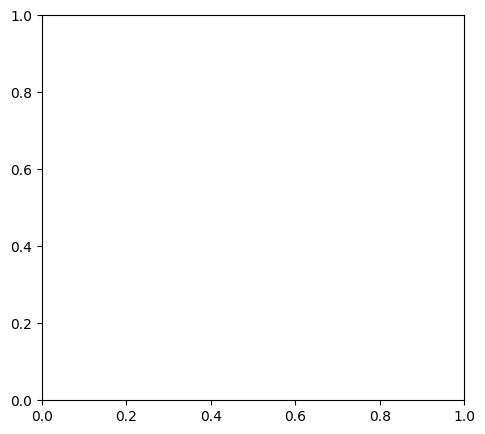

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

hist_transfer_full = load_saved_history('models/2/multi_full.npy')

# Plot training and validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist_transfer_full.history['accuracy'], label='Training Accuracy')
plt.plot(hist_transfer_full.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot training and validation loss values
plt.subplot(1, 2, 2)
plt.plot(hist_transfer_full.history['loss'], label='Training Loss')
plt.plot(hist_transfer_full.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

predictions = model_transfer_full.predict(test_generator_multi)

# Get predicted labels (argmax to get the class with the highest probability)
predicted_labels = predictions.argmax(axis=1)

# Get true labels
true_labels = test_generator_multi.classes

# Generate a classification report
report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:\n", report)


**Test code:**

In [ ]:

# Get a batch of test images and labels
test_images, test_labels = test_generator_multi.next()

# Select 10 random images and labels
indices = np.random.choice(len(test_labels), size=10, replace=False)
selected_images = test_images[indices]
selected_labels = test_labels[indices]

# Predict the classes for the selected images
predictions = model_transfer_full.predict(selected_images)
predicted_classes = np.argmax(predictions, axis=1)

# Map numerical labels to class names
class_mapping = {0: 'NORMAL', 1: 'BACTERIAL', 2: 'VIRAL'}

# Display the selected images, true classes, and predicted classes
for i in range(10):
    plt.figure(figsize=(6, 3))

    # Display the image
    plt.subplot(1, 2, 1)
    plt.imshow(selected_images[i].reshape((img_width, img_height)), cmap='gray')
    plt.title('True Class: ' + class_mapping[np.argmax(selected_labels[i])])
    plt.axis('off')

    # Display the predicted class
    plt.subplot(1, 2, 2)
    plt.bar(range(3), predictions[i], tick_label=list(class_mapping.values()))
    plt.title('Predicted Class: ' + class_mapping[predicted_classes[i]])
    plt.show()



In [ ]:
from keras.src.utils import plot_model

# We want to plot the model
plot_model(model_transfer_full, to_file='model.png', show_shapes=True, show_layer_names=True)

# **Task 3 - KNN**

In [ ]:
# Extract embeddings from the last layer of the model
embedding_model = Model(inputs=model_transfer_full.input, outputs=model_transfer_full.layers[-2].output)

# Get embeddings for all images in the test set
embeddings = []
labels = []

for batch in tqdm(range(test_generator_multi.samples // 16)):
    test_images, test_labels = next(test_generator_multi)
    batch_embeddings = embedding_model.predict(test_images)
    embeddings.extend(batch_embeddings)
    labels.extend(np.argmax(test_labels, axis=1))

embeddings = np.array(embeddings)
labels = np.array(labels)

# Train a k-Nearest Neighbors (KNN) classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(embeddings, labels)

# Test the KNN classifier on a new image
def classify_new_image(image_path, knn_classifier, embedding_model):
    img = image.load_img(image_path, target_size=(img_width, img_height), color_mode='grayscale')
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize

    # Get the embedding vector
    embedding_vector = embedding_model.predict(img_array)

    # Use KNN classifier to predict the class
    predicted_class = knn_classifier.predict(embedding_vector)

    return predicted_class[0]

# Test the classifier on a new image
new_image_path = 'dataset/chest_xray/chest_xray/test/BACTERIAL/person100_bacteria_475.jpeg'
predicted_class = classify_new_image(new_image_path, knn_classifier, embedding_model)

print(f'Predicted Class for the New Image: {predicted_class}')

# Visualize embeddings using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)
# Visualize the embeddings in a scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Embeddings')
plt.legend(*scatter.legend_elements(), title='Classes')
plt.savefig('tsne.png')
plt.show()

# 2 is viral, 0 is normal, 1 is bacterial

NameError: name 'model_transfer_full' is not defined

# **Task 3/4 - Anomaly Detection**

In [ ]:
epochs = 1500

healthy

In [ ]:
# Load the autoencoder model
autoencoder_model_path = f'models/4/autoencoder_checkpoint500.h5'
autoencoder = load_model(autoencoder_model_path)
# model_full_report(autoencoder,history, test_generator_sick)
# Load the original image
image_path = 'dataset/chest_xray/train/NORMAL/IM-0117-0001.jpeg'
img = image.load_img(image_path, target_size=(256, 256), color_mode='grayscale')
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get the reconstructed image from the autoencoder
reconstructed_img = autoencoder.predict(img_array)

# Compute the reconstruction error
reconstruction_error = np.mean(np.square(reconstructed_img - img_array))

# Set a threshold for highlighting areas with high reconstruction error
threshold = 0.001

# Display the images and information with thresholding
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_img[0, :, :, 0], cmap='gray')
plt.title('Reconstructed Image')

# Reconstruction Error with Threshold
plt.subplot(1, 3, 3)
error_image = np.abs(reconstructed_img[0, :, :, 0] - img_array[0, :, :, 0])
thresholded_error = np.where(error_image > threshold, error_image, 0)
plt.imshow(thresholded_error, cmap='gray')
plt.title(f'Reconstruction Error ({threshold}): {reconstruction_error:.4f}')

plt.tight_layout()
plt.savefig('reconstruction_error256_466_500.png')
plt.show()

NameError: name 'load_model' is not defined

virus

1/1 [==============================] - 2s 2s/step


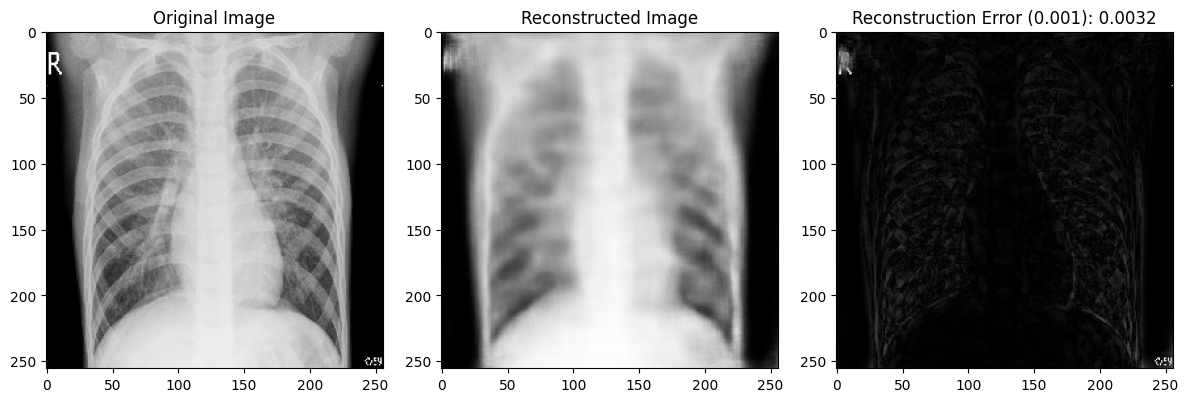

In [ ]:
# Load the autoencoder model
autoencoder_model_path = f'models/4/autoencoder_checkpoint500.h5'
autoencoder = load_model(autoencoder_model_path)
# model_full_report(autoencoder,history, test_generator_sick)
# Load the original image
image_path = 'dataset/chest_xray/train/PNEUMONIA/person1077_virus_1787.jpeg'
img = image.load_img(image_path, target_size=(256, 256), color_mode='grayscale')
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get the reconstructed image from the autoencoder
reconstructed_img = autoencoder.predict(img_array)

# Compute the reconstruction error
reconstruction_error = np.mean(np.square(reconstructed_img - img_array))

# Set a threshold for highlighting areas with high reconstruction error
threshold = 0.001

# Display the images and information with thresholding
plt.figure(figsize=(12, 12))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

# Reconstructed Image
plt.subplot(1, 3, 2)
plt.imshow(reconstructed_img[0, :, :, 0], cmap='gray')
plt.title('Reconstructed Image')

# Reconstruction Error with Threshold
plt.subplot(1, 3, 3)
error_image = np.abs(reconstructed_img[0, :, :, 0] - img_array[0, :, :, 0])
thresholded_error = np.where(error_image > threshold, error_image, 0)
plt.imshow(thresholded_error, cmap='gray')
plt.title(f'Reconstruction Error ({threshold}): {reconstruction_error:.4f}')

plt.tight_layout()
plt.savefig('reconstruction_error256_467_500.png')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

# Set paths
train_data_dir = 'dataset/chest_xray/train'
test_data_dir = 'dataset/chest_xray/test'

# Define parameters for the data generator
img_width, img_height = 256, 256  # Adjust the size based on your model requirements
batch_size = 32

# Create an ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='input',  # Input and target are the same (autoencoder)
                                                  color_mode='grayscale',
                                                  classes=['NORMAL'])
anomaly_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='input',  # Input and target are the same (autoencoder)
                                                  color_mode='grayscale',
                                                  classes=['PNEUMONIA'])

# Load the trained autoencoder
autoencoder = load_model(f'models/4/autoencoder_checkpoint500.h5')
autoencoder.load_weights(f'models/4/autoencoder_checkpoint500.h5')

# Function to generate heatmap
def generate_heatmap(original_img, reconstructed_img, threshold):
    mse = np.mean((original_img - reconstructed_img)**2, axis=-1)
    anomaly_mask = mse > threshold
    return anomaly_mask

# Choose a threshold for anomaly detection
threshold = 0.0005  # Adjust this threshold based on your evaluation

# Load an example image for testing
example_img, _ = test_generator.next()
anomaly_img, _ = anomaly_generator.next()

# Reconstruct the image using the autoencoder
reconstructed_img = autoencoder.predict(example_img)
reconstructed_img_anomaly = autoencoder.predict(anomaly_img)

# Generate the anomaly heatmap
heatmap = generate_heatmap(example_img, reconstructed_img, threshold)

for i in range(len(test_generator)):
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(example_img[i]), cmap='gray_r')  # Use 'gray_r' to reverse the colormap
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(reconstructed_img[i]), cmap='gray_r')  # Use 'gray_r' to reverse the colormap
    plt.title('Reconstructed Image')

    # Plot the heatmap on the original image
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(example_img[i]), cmap='gray_r')  # Use 'gray_r' to reverse the colormap
    plt.imshow(heatmap[i], cmap='jet', alpha=0.5)  # Use 'hot' colormap for the heatmap
    plt.title('Anomaly Heatmap')

    plt.tight_layout()
    plt.show()
print('Anomaly')
# Generate the anomaly heatmap
heatmap = generate_heatmap(anomaly_img, reconstructed_img_anomaly, threshold)
for i in range(len(anomaly_generator)):
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(anomaly_img[i]), cmap='gray_r')  # Use 'gray_r' to reverse the colormap
    plt.title('Original Image')
    #reconstructed_img_anomaly
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(reconstructed_img_anomaly[i]), cmap='gray_r')  # Use 'gray_r' to reverse the colormap
    plt.title('Reconstructed Image')

    # Plot the heatmap on the original image
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(anomaly_img[i]), cmap='gray_r')  # Use 'gray_r' to reverse the colormap
    plt.imshow(heatmap[i], cmap='jet', alpha=0.5)  # Use 'hot' colormap for the heatmap
    plt.title('Anomaly Heatmap')

    plt.tight_layout()
    plt.show()

Found 234 images belonging to 1 classes.
Found 390 images belonging to 1 classes.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

# Assuming you have defined the 'autoencoder' model somewhere before this code
# and 'anomaly_img' is a list of images.

img = anomaly_img[0]
print(autoencoder.layers)
# Get weights from the prediction layer (Only weights, not biases)
last_layer_weights = autoencoder.layers[-1].get_weights()[0]

# Get weights for the predicted class (assuming binary classification)
last_layer_weights_for_pred = last_layer_weights[:, 0]

# Get output from the last conv layer
last_conv_model = Model(autoencoder.input, autoencoder.layers[-43].output)
last_conv_output = last_conv_model.predict(img[np.newaxis, :, :, :])
last_conv_output = np.squeeze(last_conv_output)

# Upsample the last conv output without scipy
h, w = img.shape[0], img.shape[1]
upsampled_last_conv_output = tf.image.resize(last_conv_output, (h, w))

# Multiply each feature map from the upsampled_last_conv_output with corresponding weights
heat_map = np.dot(upsampled_last_conv_output, last_layer_weights_for_pred)

# Display the original image and the heat map side by side
plt.subplot(1, 2, 1)
plt.imshow(img , cmap = 'gray_r')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img , cmap = 'gray_r')
plt.imshow(np.sum(upsampled_last_conv_output.numpy(), axis=-1), cmap='jet', alpha = 0.5)  # Display the sum across channels
plt.title('Heat Map')
plt.tight_layout()
plt.savefig('anomalyheatmap.png')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
import tensorflow as tf

# Assuming you have defined the 'autoencoder' model somewhere before this code
# and 'example_img' is a list of images.

img = example_img[0]

# Get weights from the prediction layer (Only weights, not biases)
last_layer_weights = autoencoder.layers[-1].get_weights()[0]

# Get weights for the predicted class (assuming binary classification)
last_layer_weights_for_pred = last_layer_weights[:, 0]

# Get output from the last conv layer
last_conv_model = Model(autoencoder.input, autoencoder.layers[-43].output)
last_conv_output = last_conv_model.predict(img[np.newaxis, :, :, :])
last_conv_output = np.squeeze(last_conv_output)

# Upsample the last conv output without scipy
h, w = img.shape[0], img.shape[1]
upsampled_last_conv_output = tf.image.resize(last_conv_output, (h, w))

# Multiply each feature map from the upsampled_last_conv_output with corresponding weights
heat_map = np.dot(upsampled_last_conv_output, last_layer_weights_for_pred)

# Display the original image and the heat map side by side
plt.subplot(1, 2, 1)
plt.imshow(img , cmap = 'gray_r')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(img , cmap = 'gray_r')
plt.imshow(np.sum(upsampled_last_conv_output.numpy(), axis=-1), cmap='jet' ,alpha = 0.5)  # Display the sum across channels
plt.title('Heat Map')
plt.tight_layout()
plt.savefig('anomalyheatmap.png')
plt.show()
